In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

In [2]:
#train = pd.read_csv('data/train.csv')
train = pd.read_csv('data/clean.txt').drop(columns=['Unnamed: 0'])
train

,ID,text,label
0,SUAVK39Z,I feel better I dieAm happy,Depression
1,9JDAGUV3,Why I get hallucinations,Drugs
2,419WR1LQ,I stresseed due lack financial support school,Depression
3,6UY7DX6Q,Why life important,Suicide
4,FYC0FTFB,How could I helped go depression,Depression
...,...,...,...
611,BOHSNXCN,What I stop alcoholism,Alcohol
612,GVDXRQPY,How become oldself,Suicide
613,IO4JHIQS,How someone stop,Alcohol
614,1DS3P1XO,I feel unworthy,Depression


In [3]:
x_value = train['text']
y_value = train['label']#.replace({'Depression': 0, 'Drugs': 1, 'Suicide': 2, 'Alcohol': 4})
x_train, x_test, y_train, y_test = train_test_split(x_value, y_value, test_size=0.25)

In [16]:
#depress = x_train[x_train['label'] == 'Depression']
#drugs = x_train[x_train['label'] == 'Drugs']
#suic = x_train[x_train['label'] == 'Suicide']
#alc = x_train[x_train['label'] == 'Alcohol']

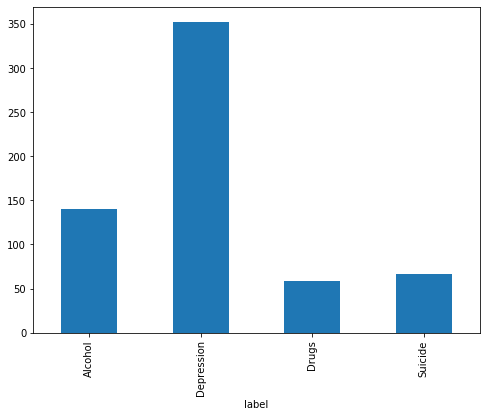

In [17]:
fig = plt.figure(figsize=(8,6))
train.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [4]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',\
                        ngram_range=(1, 2), stop_words='english')
#features = tfidf.fit_transform(x_train).toarray()
#labels = y_train
#features.shape

In [5]:
vect = CountVectorizer()
#x_train_counts = vect.fit_transform(x_train)
#x_train_counts = tfidf.fit_transform(x_train)
x_train_counts = tfidf.fit_transform(x_value)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
#clf = MultinomialNB().fit(x_train_tfidf, y_value)
#clf = LogisticRegression(solver='liblinear',multi_class='auto').fit(x_train_tfidf, y_value)
#clf = LinearSVC().fit(x_train_tfidf, y_value)
#clf = RandomForestClassifier(n_estimators=20, max_depth=3).fit(x_train_tfidf, y_train)
#clf = KNeighborsClassifier().fit(x_train_tfidf, y_train)
clf = CalibratedClassifierCV(SGDClassifier(), cv=5).fit(x_train_tfidf, y_value)

In [23]:
print(clf.predict(tfidf.transform(["I feel that it was better I dieAm happy"])))

['Depression']


In [24]:
print(clf.predict_log_proba(vect.transform(["I feel that it was better I dieAm happy"])))

[[-7.33578188e+00 -1.76133209e-03 -7.41367269e+00 -7.59088162e+00]]


In [22]:
print(clf.predict_proba(tfidf.transform(["I feel that it was better I dieAm happy"])))

[[0.03193173 0.89796692 0.02089027 0.04921108]]


In [10]:
print(clf.predict(tfidf.transform(["How can someone stop it?"])))

['Alcohol']


In [11]:
print(clf.predict_proba(tfidf.transform(["How can someone stop it?"])))

[[0.72618845 0.09465294 0.11539234 0.06376627]]


In [12]:
print(clf.predict(vect.transform(["Causes of suicide by youths"])))

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

In [40]:
print(clf.predict_proba(vect.transform(["Causes of suicide by youths"])))

[[0.19494214 0.25240664 0.01884591 0.53380531]]


In [45]:
print(clf.predict(vect.transform(["What are the effects of smoking bhang?"])))

['Drugs']


In [46]:
print(clf.predict_proba(vect.transform(["What are the effects of smoking bhang?"])))

[[0.19589638 0.14940968 0.65248128 0.00221266]]


In [24]:
np.count_nonzero(clf.predict(tfidf.transform(x_test)) == y_test)/len(x_test)

0.8376623376623377

In [25]:
np.count_nonzero(clf.predict(tfidf.transform(x_train)) == y_train)/len(x_train)

0.8809523809523809

In [6]:
test = pd.read_csv('data/test.csv')
test

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
...,...,...
304,Z9A6ACLK,Yes
305,ZDUOIGKN,My girlfriend dumped me
306,ZHQ60CCH,How can I go back to being my old self?
307,ZVIJMA4O,Is it true bhang is medicinal?


In [7]:
results = clf.predict_proba(tfidf.transform(test['text']))

In [8]:
output = pd.DataFrame(results, columns=['Alcohol', 'Depression', 'Drugs', 'Suicide'])
order = ['Depression', 'Alcohol', 'Suicide', 'Drugs']
output = output[order]
output.insert(0, 'ID', test.ID)

In [9]:
output.to_csv('data/output.csv', index=False)

In [ ]:
log_loss(np.array(y_test), clf.predict(tfidf.transform(x_test)), eps=1e-15)

In [106]:
clf.predict(tfidf.transform(x_test))

array(['Depression', 'Depression', 'Drugs', 'Depression', 'Suicide',
       'Depression', 'Depression', 'Depression', 'Alcohol', 'Depression',
       'Depression', 'Depression', 'Alcohol', 'Alcohol', 'Depression',
       'Depression', 'Depression', 'Alcohol', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Suicide', 'Alcohol',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depression', 'Suicide', 'Depression', 'Depression',
       'Alcohol', 'Depression', 'Alcohol', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Alcohol', 'Depression',
       'Depression', 'Depression', 'Depression', 'Suicide', 'Drugs',
       'Depression', 'Depression', 'Depression', 'Depression', 'Suicide',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depre

In [112]:
np.array(y_test)

array(['Depression', 'Depression', 'Drugs', 'Alcohol', 'Suicide',
       'Depression', 'Depression', 'Depression', 'Alcohol', 'Suicide',
       'Depression', 'Depression', 'Alcohol', 'Alcohol', 'Depression',
       'Depression', 'Suicide', 'Drugs', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Suicide', 'Alcohol',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depression', 'Depression', 'Depression',
       'Depression', 'Depression', 'Suicide', 'Suicide', 'Depression',
       'Alcohol', 'Alcohol', 'Alcohol', 'Depression', 'Depression',
       'Drugs', 'Depression', 'Depression', 'Alcohol', 'Depression',
       'Depression', 'Depression', 'Depression', 'Suicide', 'Drugs',
       'Depression', 'Depression', 'Depression', 'Depression', 'Suicide',
       'Depression', 'Depression', 'Depression', 'Alcohol', 'Depression',
       'Depression', 'Depression', 'De